In [23]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
main_start = datetime.now()
%matplotlib inline

In [24]:
raw_data = pd.read_csv('2007.csv')
list(raw_data.columns)


['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'ArrTime',
 'CRSArrTime',
 'UniqueCarrier',
 'FlightNum',
 'TailNum',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'Origin',
 'Dest',
 'Distance',
 'TaxiIn',
 'TaxiOut',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

In [25]:
raw_data.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn                 int64
TaxiOut                int64
Cancelled              int64
CancellationCode      object
Diverted               int64
CarrierDelay           int64
WeatherDelay           int64
NASDelay               int64
SecurityDelay          int64
LateAircraftDelay      int64
dtype: object

In [26]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

DepTime               160748
ArrTime               177927
TailNum                   22
ActualElapsedTime     177927
CRSElapsedTime           994
AirTime               177927
ArrDelay              177927
DepDelay              160748
CancellationCode     7292466
dtype: int64

In [27]:
#Get rid of flights that were cancelled since they couldn't be late.
df2007 = raw_data[raw_data.CancellationCode.isnull()]

#Get rid of Cancellation code since it comes up only when an aircraft is cancelled. We also won't need Year since it's 2007.
df2007 = df2007.drop(['Year', 'FlightNum', 'TailNum', 'Dest', 'Cancelled', 'Diverted', 'CancellationCode'], 1)
# Count nulls 
null_count = df2007.isnull().sum()
null_count[null_count>0]

ArrTime              17179
ActualElapsedTime    17179
CRSElapsedTime         727
AirTime              17179
ArrDelay             17179
dtype: int64

In [28]:
#Dropping out cancelled flights got rid of the majority of our nulls. The rest seem to be issues with Arrival time/delay, so let's get rid of them all. 
df2007 = df2007.dropna()
null_count = df2007.isnull().sum()
null_count[null_count>0]

Series([], dtype: int64)

In [29]:
#Turn this into a classification with the definition that a late plane is one that arrives 30 minutes or more late.
threshold = 30.0
df2007['Late'] = np.where(df2007['ArrDelay'] >= threshold, 1,0)

In [30]:
print(df2007['Late'].value_counts())

0    6177946
1    1097341
Name: Late, dtype: int64


In [31]:
airlines_ontime = df2007[df2007.Late == 0]
airlines_delay = df2007[df2007.Late == 1]

df3 = resample(airlines_ontime, n_samples=9734)
airlines_delay = resample(airlines_delay, n_samples=9734)

df3 = df3.append(airlines_delay)
df3['Late'].value_counts()

1    9734
0    9734
Name: Late, dtype: int64

It took the following time to complete this task: 0:00:08.690395


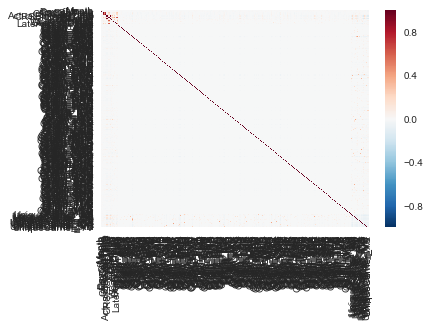

In [32]:
start = datetime.now()
#Turn the string features into dummies
df3 = pd.get_dummies(df3, columns=['Origin', 'UniqueCarrier'])
sns.heatmap(df3.corr())
print('It took the following time to complete this task:', datetime.now() - start)

In [33]:
X = df3.drop(['ArrDelay', 'Late'], 1)
y = df3['Late']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
start = datetime.now()
#Use Lasso/RFECV to get the best features
lr = LogisticRegression(C=1, penalty='l1')

#Set up our X,y
X = X_train
y = y_train

#Set up our Recursive Feature Elimination with Cross Validation
"""rfecv = RFECV(lr, cv=10) 
fit = rfecv.fit(X,y)
result_RFECV = pd.DataFrame(list(zip(X.head(0), rfecv.ranking_, rfecv.support_)),
                          columns=['Features','Ranking','Support'] ) 
print(result_RFECV.sort_values('Ranking'))"""
print('It took the following time to complete this task:', datetime.now() - start)

It took the following time to complete this task: 0:00:00.009083


In [35]:
"""true_values = result_RFECV[result_RFECV.Support == True]
feature_list = []
for feature in true_values['Features']:
    feature_list.append(feature)
sns.heatmap(X_train[feature_list].corr())"""

"true_values = result_RFECV[result_RFECV.Support == True]\nfeature_list = []\nfor feature in true_values['Features']:\n    feature_list.append(feature)\nsns.heatmap(X_train[feature_list].corr())"

In [36]:
#Select features with PCA
pca = PCA(n_components=15)
X_std_pca = pca.fit_transform(X_train)
X1 = pd.DataFrame(X_std_pca)

#Now for the Test
pca = PCA(n_components=25)
X_std_pca = pca.fit_transform(X_test)
X1_test = pd.DataFrame(X_std_pca)

In [37]:
#Set our X, y variables
"""X = X_train[feature_list]
y = y_train
X_test = X_test[feature_list]"""



'X = X_train[feature_list]\ny = y_train\nX_test = X_test[feature_list]'

In [38]:
def testing_func(model):
    """model.fit(X, y)"""
    model.fit(X1, y)

    # Inspect the results.
    """print('\nR-squared for the Training Set with RFECV features:')
    print(model.score(X, y))"""
    print('\nR-squared for the Training Set with PCA:')
    print(model.score(X1, y))
    """print('Cross Validation Scores with 10 folds for RFECV Features: {}'.format(cross_val_score(model, X, y, cv=10)))"""
    print('Cross Validation Scores with 10 folds for PCA: {}'.format(cross_val_score(model, X1, y, cv=10)))

In [39]:
start = datetime.now()
#Let's pop those into the model
lr = LogisticRegression(C=9e9)
testing_func(lr)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set with PCA:
0.997303197637
Cross Validation Scores with 10 folds for PCA: [ 0.99807445  0.99679076  0.99614891  0.99807445  0.99614891  0.99807322
  0.99743096  0.99743096  0.99807322  0.99871465]
It took the following time to complete this task: 0:00:05.493038


In [40]:
start = datetime.now()
#Let's pop those into the model
lr = LogisticRegression(C=1, penalty='l1')
testing_func(lr)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set with PCA:
0.995954796456
Cross Validation Scores with 10 folds for PCA: [ 0.99550706  0.99486521  0.99486521  0.99486521  0.99486521  0.99614644
  0.9967887   0.9967887   0.99743096  0.99678663]
It took the following time to complete this task: 0:00:21.550571


In [41]:
start = datetime.now()
#Let's pop those into the model
lr = LogisticRegression(C=1, penalty='l2')
testing_func(lr)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set with PCA:
0.997110568897
Cross Validation Scores with 10 folds for PCA: [ 0.99679076  0.99614891  0.99486521  0.99743261  0.99486521  0.99807322
  0.99743096  0.9967887   0.99743096  0.99807198]
It took the following time to complete this task: 0:00:04.851402


In [42]:
start = datetime.now()
neighbors = KNeighborsClassifier(n_neighbors=5)
testing_func(neighbors)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set with PCA:
0.939964042635
Cross Validation Scores with 10 folds for PCA: [ 0.91848524  0.88896021  0.89794608  0.90500642  0.90885751  0.90687219
  0.90751445  0.9132948   0.90044958  0.89460154]
It took the following time to complete this task: 0:00:01.084161


In [43]:
start = datetime.now()
clf_1 = DecisionTreeClassifier(max_depth=5)
clf_2 = DecisionTreeClassifier(max_depth=9)
testing_func(clf_1)
testing_func(clf_2)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set with PCA:
0.956209066393
Cross Validation Scores with 10 folds for PCA: [ 0.95442875  0.95057766  0.94865212  0.94159178  0.95314506  0.94348105
  0.94348105  0.94412331  0.93641618  0.95501285]

R-squared for the Training Set with PCA:
0.986965455246
Cross Validation Scores with 10 folds for PCA: [ 0.96084724  0.95699615  0.95892169  0.95699615  0.94929397  0.95761079
  0.95953757  0.96531792  0.95183044  0.96915167]
It took the following time to complete this task: 0:00:03.628880


In [44]:
print('It took the following time to complete this project:', datetime.now() - main_start)

It took the following time to complete this project: 0:01:41.449501
